In [87]:
import pandas as pd

df = pd.read_csv('housing.csv')

# Data Preprocessing

In [88]:
df.isna().sum().sum(), df.isnull().sum().sum()

df = df.dropna() # ~1.5% data

In [89]:
df.sample(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12171,-117.15,33.70,2.0,6305.0,1265.0,2489.0,1152.0,3.1319,111500.0,INLAND
20234,-119.27,34.27,44.0,1312.0,279.0,668.0,278.0,4.0900,203800.0,NEAR OCEAN
2544,-124.16,40.78,50.0,2285.0,403.0,837.0,353.0,2.5417,85400.0,NEAR OCEAN


In [90]:
df['ocean_proximity'].value_counts()

,count
ocean_proximity,
<1H OCEAN,9034
INLAND,6496
NEAR OCEAN,2628
NEAR BAY,2270
ISLAND,5


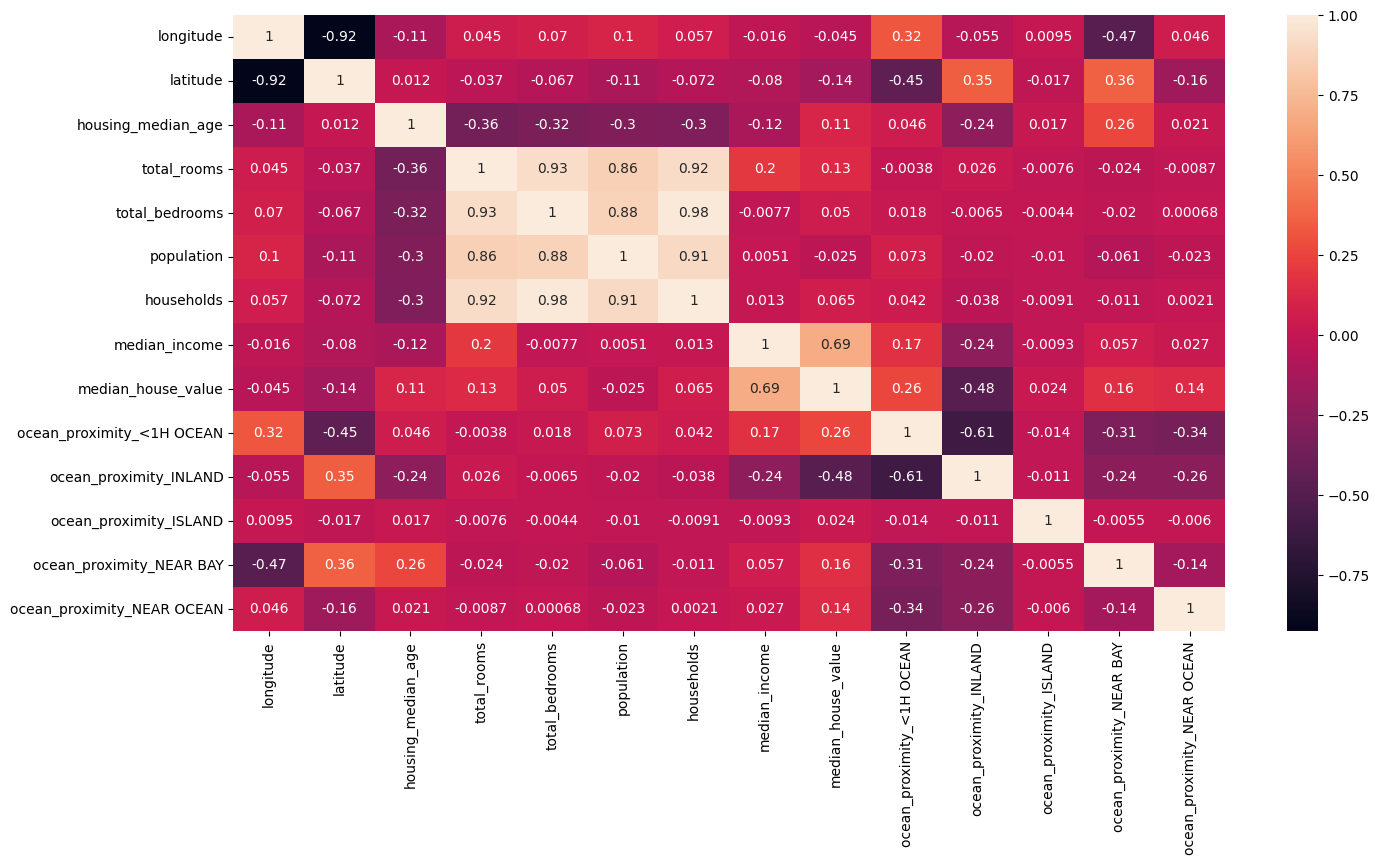

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
sns.heatmap(pd.get_dummies(df, columns=['ocean_proximity']).corr(), annot=True)
plt.show()

In [92]:
from sklearn.model_selection import train_test_split

x = df.drop(columns=['median_house_value'], axis=1)
y = df['median_house_value']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train.shape, y_train.shape

((16346, 9), (16346,))

In [93]:
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

transformer = ColumnTransformer([
    # Order based on data from heatmap
    ('ordinalencoding', OrdinalEncoder(categories=[['INLAND', 'ISLAND', 'NEAR OCEAN', 'NEAR BAY', '<1H OCEAN']]), ['ocean_proximity']),

    # Scaling data
    ('scale', StandardScaler(), x.columns.drop('ocean_proximity')),
], remainder='passthrough')

# Convert back to dataframe
x_train = pd.DataFrame(transformer.fit_transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(transformer.transform(x_test), columns=x_train.columns)

# Project Tasks

### **Part 1. Pure Python Implementation**
### *Multivariable Linear Regression with Gradient Descent as optimization technique*

In [94]:
class MLRGD_Core:
    def __init__(self, learning_rate=0.01, epochs=100):
        self.coef = None
        self.intercept = None

        self.lr = learning_rate
        self.epochs = epochs

        self.t2c = None        # Time to Converge

        self.error = []        # To store error at each epoch
        self.iterations = []   # To store iteration numbers

    def fit(self, x, y):
        self.intercept = 0 # Assuming zero
        self.coef = [1 for i in range(len(x[1]))] # Assuming with all ones

        self.t2c = time.time()

        for i in range(self.epochs):
            y_hat = [(self.intercept + sum([self.coef[k] * x[j][k] for k in range(len(x[j]))])) for j in range(len(x))]
            der_intercept = -2 * (sum([y[j] - y_hat[j] for j in range(len(x))]) / len(x))

            self.error.append(np.mean((y_train - y_hat) ** 2))
            self.iterations.append(i)

            for j in range(len(x[0])):
                der_coef_j = -2 * (sum([(y[k] - y_hat[k]) * x[k][j] for k in range(len(x))]) / len(x))
                self.coef[j] = self.coef[j] - (self.lr * der_coef_j)

            self.intercept = self.intercept - (self.lr * der_intercept)

        self.t2c = time.time() - self.t2c

    def predict(self, x):
        return [(self.intercept + sum([self.coef[k] * x[j][k] for k in range(len(x[j]))])) for j in range(len(x))]

### **Part 2. Optimized NumPy Implementation**

In [95]:
import numpy as np
import time

class MLRGD:
    def __init__(self, learning_rate=0.01, epochs=100):
        self.coef = None
        self.intercept = None

        self.lr = learning_rate
        self.epochs = epochs

        self.t2c = None        # Time to Converge

        self.error = []        # To store error at each epoch
        self.iterations = []   # To store iteration numbers

    def fit(self, x_train, y_train):
        n_rows, n_features = x_train.shape

        self.intercept = 0 # Assuming zero
        self.coef = np.ones(n_features) # Assuming all ones

        self.t2c = time.time()

        for i in range(self.epochs):
            y_hat = np.dot(x_train, self.coef) + self.intercept

            self.error.append(np.mean((y_train - y_hat) ** 2))
            self.iterations.append(i)

            der_intercept = -2 * np.mean(y_train - y_hat)
            der_coef = -2 * (np.dot((y_train - y_hat), x_train) / n_rows)

            self.coef = self.coef - (self.lr * der_coef)
            self.intercept = self.intercept - (self.lr * der_intercept)

        self.t2c = time.time() - self.t2c

    def predict(self, x_test):
        return np.dot(x_test, self.coef) + self.intercept

### **Part 3. Scikit-learn Implementation**

In [96]:
from sklearn.linear_model import LinearRegression

In [97]:
learning_rate = 0.1
epochs = 400

# Creating object for different approach
mlr = LinearRegression()
mlrgd = MLRGD(learning_rate, epochs)
mlrgd_core = MLRGD_Core(learning_rate, epochs)

# Fitting Data
start_time_mlr = time.time()
mlr.fit(x_train, y_train)
end_time_mlr = time.time()

mlrgd.fit(x_train, y_train)
mlrgd_core.fit(x_train.values.tolist(), y_train.values.tolist())

# Evaluation Criteria

### Part 1. Convergence Time

In [98]:
print("Converge Time for")
print("---------------------------")
print("")

print("Core Python Implementation  :", mlrgd_core.t2c, "seconds")
print("NumPy Implementation        :", mlrgd.t2c, "seconds")
print("Scikit-learn Implementation :", end_time_mlr - start_time_mlr, "seconds")

Converge Time for
---------------------------

Core Python Implementation  : 30.001676321029663 seconds
NumPy Implementation        : 0.4380819797515869 seconds
Scikit-learn Implementation : 0.009918689727783203 seconds


### Part 2. Performance Metrics

In [99]:
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

In [100]:
# Print average scores on Test Data

y_pred_mlrgd_core_test = mlrgd_core.predict(x_test.values.tolist())
y_pred_mlrgd_test = mlrgd.predict(x_test)
y_pred_mlr_test = mlr.predict(x_test)

score_test = {
    "mlrgd_core": {
        "r2": r2_score(y_test, y_pred_mlrgd_core_test),
        "mae": mean_absolute_error(y_test, y_pred_mlrgd_core_test),
        "rmse": root_mean_squared_error(y_test, y_pred_mlrgd_core_test)
    },
    "mlrgd": {
        "r2": r2_score(y_test, y_pred_mlrgd_test),
        "mae": mean_absolute_error(y_test, y_pred_mlrgd_test),
        "rmse": root_mean_squared_error(y_test, y_pred_mlrgd_test)
    },
    "mlr": {
        "r2": r2_score(y_test, y_pred_mlr_test),
        "mae": mean_absolute_error(y_test, y_pred_mlr_test),
        "rmse": root_mean_squared_error(y_test, y_pred_mlr_test)
    },
}

print("Average Scores on test Data")
print("---------------------------")
print("")

# 1. Core Python Implementation
print("Core Impl R² Score    :", score_test['mlrgd_core']['r2'])
print("Core Impl MAE         :", score_test['mlrgd_core']['mae'])
print("Core Impl RMSE        :", score_test['mlrgd_core']['rmse'])
print()

# 2. Numpy Implementation
print("Numpy Impl R² Score   :", score_test['mlrgd']['r2'])
print("Numpy Impl MAE        :", score_test['mlrgd']['mae'])
print("Numpy Impl RMSE       :", score_test['mlrgd']['rmse'])
print()

# 3. Scikit-learn Implementation
print("Scikit-Learn R² Score :", score_test['mlr']['r2'])
print("Scikit-Learn MAE      :", score_test['mlr']['mae'])
print("Scikit-Learn RMSE     :", score_test['mlr']['rmse'])

Average Scores on test Data
---------------------------

Core Impl R² Score    : 0.6331856904535742
Core Impl MAE         : 50797.09200757756
Core Impl RMSE        : 69873.46584681225

Numpy Impl R² Score   : 0.6331856904535741
Numpy Impl MAE        : 50797.09200757755
Numpy Impl RMSE       : 69873.46584681225

Scikit-Learn R² Score : 0.6333617641500217
Scikit-Learn MAE      : 50805.64326525273
Scikit-Learn RMSE     : 69856.69393276922


In [101]:
# Print average scores on Train Data

y_pred_mlrgd_core_train = mlrgd_core.predict(x_train.values.tolist())
y_pred_mlrgd_train = mlrgd.predict(x_train)
y_pred_mlr_train = mlr.predict(x_train)

score_train = {
    "mlrgd_core": {
        "r2": r2_score(y_train, y_pred_mlrgd_core_train),
        "mae": mean_absolute_error(y_train, y_pred_mlrgd_core_train),
        "rmse": root_mean_squared_error(y_train, y_pred_mlrgd_core_train)
    },
    "mlrgd": {
        "r2": r2_score(y_train, y_pred_mlrgd_train),
        "mae": mean_absolute_error(y_train, y_pred_mlrgd_train),
        "rmse": root_mean_squared_error(y_train, y_pred_mlrgd_train)
    },
    "mlr": {
        "r2": r2_score(y_train, y_pred_mlr_train),
        "mae": mean_absolute_error(y_train, y_pred_mlr_train),
        "rmse": root_mean_squared_error(y_train, y_pred_mlr_train)
    },
}

print("Average Scores on train Data")
print("---------------------------")
print("")

# 1. Core Python Implementation
print("Core Impl R² Score    :", score_train['mlrgd_core']['r2'])
print("Core Impl MAE         :", score_train['mlrgd_core']['mae'])
print("Core Impl RMSE        :", score_train['mlrgd_core']['rmse'])
print()

# 2. Numpy Implementation
print("Numpy Impl R² Score   :", score_train['mlrgd']['r2'])
print("Numpy Impl MAE        :", score_train['mlrgd']['mae'])
print("Numpy Impl RMSE       :", score_train['mlrgd']['rmse'])
print()

# 3. Scikit-learn Implementation
print("Scikit-Learn R² Score :", score_train['mlr']['r2'])
print("Scikit-Learn MAE      :", score_train['mlr']['mae'])
print("Scikit-Learn RMSE     :", score_train['mlr']['rmse'])

Average Scores on train Data
---------------------------

Core Impl R² Score    : 0.6446329406126605
Core Impl MAE         : 50055.183492678065
Core Impl RMSE        : 68820.75731924255

Numpy Impl R² Score   : 0.6446329406126605
Numpy Impl MAE        : 50055.183492678065
Numpy Impl RMSE       : 68820.75731924255

Scikit-Learn R² Score : 0.6448740346969118
Scikit-Learn MAE      : 50095.07529595629
Scikit-Learn RMSE     : 68797.4080917567


### Part 3. Visualization

#### Plot the cost function convergence for part 1, 2

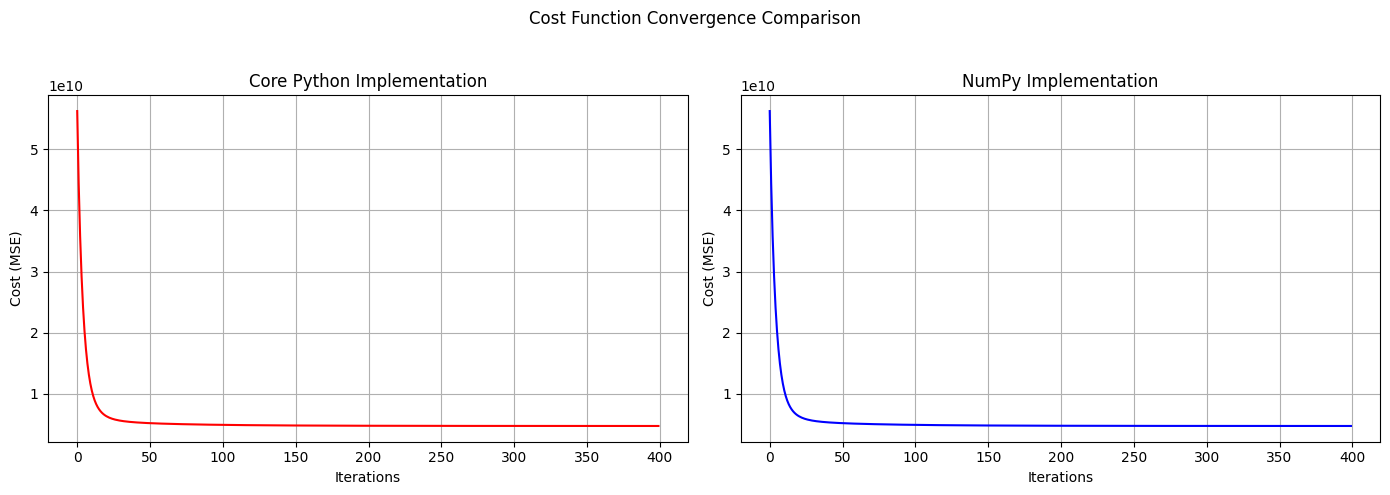

In [102]:
# Plot cost convergence
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Left: Core Python Implementation
axs[0].plot(mlrgd_core.iterations, mlrgd_core.error, color='red')
axs[0].set_title('Core Python Implementation')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Cost (MSE)')
axs[0].grid(True)

# Right: Numpy Implementation
axs[1].plot(mlrgd.iterations, mlrgd.error, color='blue')
axs[1].set_title('NumPy Implementation')
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('Cost (MSE)')
axs[1].grid(True)

# Layout adjustment
plt.suptitle('Cost Function Convergence Comparison')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### Present a bar chart contrasting the regression metrics across all three methods

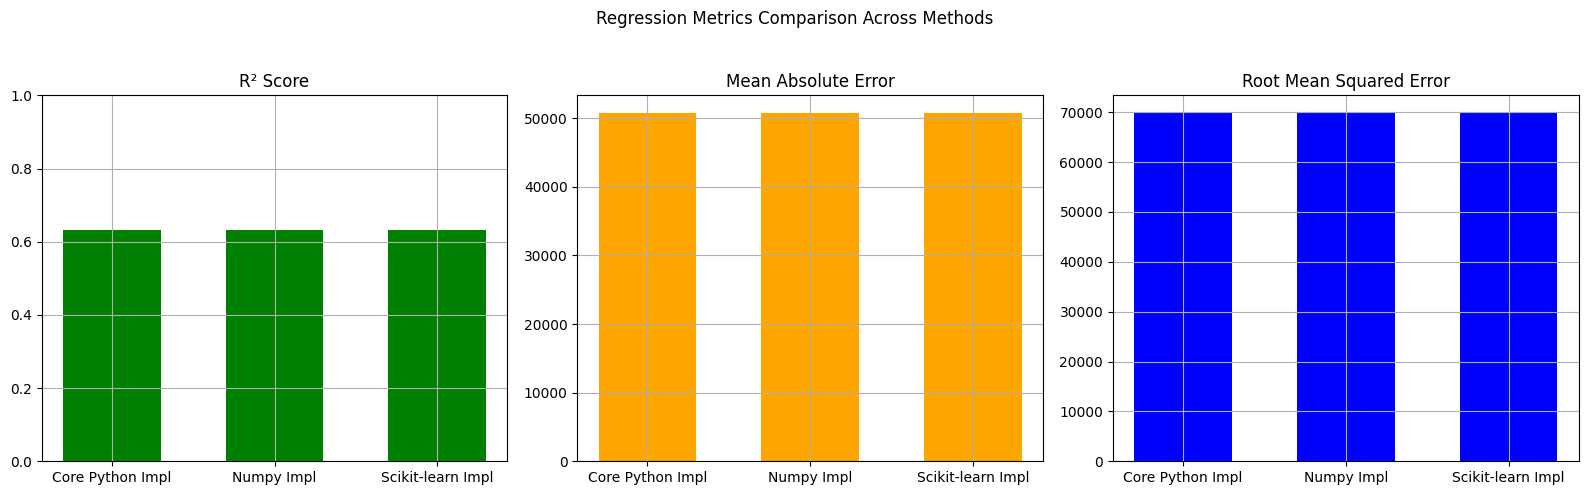

In [103]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))

methods = ['Core Python Impl', 'Numpy Impl', 'Scikit-learn Impl']
width=0.6
x=np.arange(len(methods))

# R2
axs[0].bar(x, [score_test['mlrgd_core']['r2'], score_test['mlrgd']['r2'], score_test['mlr']['r2']], color='green', width=width)
axs[0].set_title('R² Score')
axs[0].set_xticks(x)
axs[0].set_xticklabels(methods)
axs[0].set_ylim([0, 1])
axs[0].grid(True)

# MAE
axs[1].bar(x, [score_test['mlrgd_core']['mae'], score_test['mlrgd']['mae'], score_test['mlr']['mae']], color='orange', width=width)
axs[1].set_title('Mean Absolute Error')
axs[1].set_xticks(x)
axs[1].set_xticklabels(methods)
axs[1].grid(True)

# RMSE
axs[2].bar(x, [score_test['mlrgd_core']['rmse'], score_test['mlrgd']['rmse'], score_test['mlr']['rmse']], color='blue', width=width)
axs[2].set_title('Root Mean Squared Error')
axs[2].set_xticks(x)
axs[2].set_xticklabels(methods)
axs[2].grid(True)

plt.suptitle('Regression Metrics Comparison Across Methods')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()